In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion, gaussian_filter1d
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure, morphology
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
from scipy.stats import skew
import cv2
import re
from sklearn.mixture import GaussianMixture
model = models.Cellpose(gpu=False, model_type='cyto3')

c:\Users\sj1205\AppData\Local\Programs\Python\Python312\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

In [2]:
MIN_INCLUSION_SIZE = 25
MAX_INCLUSION_SIZE = 10000

In [3]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]

def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def segment_cells(green_channel):
    """
    Segment whole cells in the green channel using Cellpose.
    - Normalizes image intensity.
    - Suppresses bright spots (e.g., inclusions) to better detect cell boundaries.
    - Applies Gaussian blur for smoother segmentation input.
    - Gradually increases segmentation diameter until at least one cell is detected.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    
    # Suppress very bright pixels (inclusions)
    green_channel_remove_inclusions = np.where(green_channel < percentile_99, green_channel, percentile_99)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5)

    # Normalize again after processing
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

    # Try different diameters until cells are detected
    diameter = 150
    while diameter < 500:
        masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25

    # No cells found
    return None

def mean_curvature_from_mask(mask: np.ndarray, smooth_sigma: float = 2.0) -> float:
    contours = measure.find_contours(mask.astype(float), level=0.5)
    if not contours:
        return np.nan
    contour = max(contours, key=len)
    contour = gaussian_filter1d(contour, sigma=smooth_sigma, axis=0)
    dx = np.gradient(contour[:, 1])
    dy = np.gradient(contour[:, 0])
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    with np.errstate(divide='ignore', invalid='ignore'):
        curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    return np.nanmean(curvature)

def extract_curved_thin_objects(label_img, curvature_threshold=0.3, thinness_threshold=0.5):
    curved_thin_mask = np.zeros_like(label_img, dtype=bool)

    for region in measure.regionprops(label_img):
        mask = label_img == region.label

        # Curvature
        kappa = mean_curvature_from_mask(mask)
        if np.isnan(kappa):
            continue

        # Thinness: (4π × Area) / Perimeter² — close to 1 for round shapes
        if region.perimeter == 0:
            continue
        thinness = (4 * np.pi * region.area) / (region.perimeter ** 2)

        if kappa > curvature_threshold and thinness < thinness_threshold:
            curved_thin_mask[mask] = True

    return curved_thin_mask

def extract_inclusions(green_channel, mask, cell_number, path, display_graph=False):
    applied_mask_blurred = gaussian(green_channel, sigma=1) * mask
    #display_image(applied_mask_blurred, path, f"cell {cell_number} mask blurred")
    applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0]
    #display_image(applied_mask_eliminate_background, path, f"cell {cell_number} mask blurred eliminate background")


    # Normalize the signal within the masked region
    applied_mask_eliminate_background = normalize_image(applied_mask_eliminate_background)
    #display_image(applied_mask_eliminate_background, path, f"cell {cell_number} mask blurred eliminate background normalized")


    # Compute descriptive statistics for intensity distribution
    q3 = np.percentile(applied_mask_eliminate_background, 75)
    hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')


    max_idx = np.argmax(hist)

    # Compute the center of the peak bin
    peak_bin_count = hist[max_idx]


    applied_mask = green_channel * mask
    cell_size = np.count_nonzero(mask)
    #if (cell_size < 400):
    #    inclusions = applied_mask > 0.6
    #    inclusions = remove_small_objects(inclusions, min_size=MIN_INCLUSION_SIZE)
    #    inclusions = inclusions ^ remove_small_objects(inclusions, min_size=MAX_INCLUSION_SIZE)
    #    return inclusions

    skewness = skew(applied_mask_eliminate_background)

    # Decide on thresholding strategy based on upper quartile

    #4425 1k 3.5
    if skewness > 0.25:
        
        if peak_bin_count > 2000:
            threshold = 0.75
        else:
            threshold = .35
        print(f"skewness > 0.25 {skewness} max value {peak_bin_count}")
        print(f"Threshold: {threshold}")
    #elif skewness < -0.5:
    #    threshold = 0.6  # very high, to exclude everything
    #else:
    #    threshold = 0.999  # conservatively high
    else:
        #4425 1k 0.975 OUAT: .85
        threshold = 0.8
        print(f"skewness < 0.25 ${skewness}")
        print(f"Threshold: {threshold}")


    # Apply threshold and size-based filters
    inclusions = applied_mask > threshold
    inclusions = remove_small_objects(inclusions, min_size=MIN_INCLUSION_SIZE)
    inclusions = inclusions ^ remove_small_objects(inclusions, min_size=MAX_INCLUSION_SIZE)
    if display_graph:
        print("Threshold: ", threshold)
        print("Bin count", len(bin_edges))
        print( f"cell number: {cell_number} cell size: {cell_size} skewness: {skewness}")
        plt.hist(applied_mask_eliminate_background, bins='fd')
        plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
        plt.legend()
        plt.title("Intensity histogram")
        plt.show()

    return inclusions

def generate_inclusion_image(green_channel, labeled_cells, path):
    """
    Generate a binary image with all inclusions from all cells.
    - Loops through each segmented cell.
    - Extracts inclusions from each cell region.
    - Combines all into one final binary image.
    """
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        mask = labeled_cells == cell.label
        #display_image(mask, "mask", f"cell {i + 1}")
        inclusions = extract_inclusions(green_channel, mask, i +1, path)
        inclusion_image += inclusions  # adds binary inclusion mask

    return inclusion_image

def preprocess_green_channel(green_channel):
    """
    Preprocess the green fluorescence channel for better segmentation and inclusion detection.
    - Applies Gaussian blur to reduce noise.
    - Enhances contrast using sigmoid adjustment.
    - Normalizes intensities to [0, 1] for consistent processing.
    """
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = normalize_image(confocal_img)
    return confocal_img

def circularity_filter(mask: np.ndarray, threshold: float = 0.7):
    """
    Splits a binary mask into two masks based on circularity index.

    Parameters:
        mask (np.ndarray): Binary input mask (dtype=bool or 0/1).
        threshold (float): Circularity threshold to split regions.

    Returns:
        mask_high_circularity (np.ndarray): Mask with circular objects (circularity > threshold).
        mask_low_circularity (np.ndarray): Mask with less circular objects (circularity <= threshold).
    """

    labeled = label(mask)
    high_circularity_mask = np.zeros_like(mask, dtype=bool)
    low_circularity_mask = np.zeros_like(mask, dtype=bool)

    for region in regionprops(labeled):
        perimeter = region.perimeter
        area = region.area

        if perimeter == 0:
            continue  # Skip degenerate shapes

        circularity = 4 * np.pi * (area / (perimeter ** 2))

        coords = tuple(zip(*region.coords))
        if circularity > threshold:
            high_circularity_mask[coords] = True
        else:
            low_circularity_mask[coords] = True

    return high_circularity_mask, low_circularity_mask


def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def count_overlapping_regions(red_labeled, inclusion_mask):
    count = 0
    for region in regionprops(red_labeled):
        red_mask = np.zeros_like(inclusion_mask, dtype=bool)
        coords = tuple(zip(*region.coords))
        red_mask[coords] = True
        if np.any(red_mask & inclusion_mask):
            count += 1
    return count



In [4]:
def analysis(red, green, path):
    data = []
    green_channel = preprocess_green_channel(green)
    #display_image(green_channel, path, "Preprocessed Green Channel")

    # Segment individual cells from the green channel
    labeled_cells = segment_cells(green_channel)
    #display_image(labeled_cells, path, "Labeled Cells")
    inclusions_image = generate_inclusion_image(green_channel, labeled_cells, path)
    display_image(inclusions_image, path, "Inclusions Image")
    
    red_channel = normalize_image(red)
    red_channel = red_channel > threshold_otsu(red_channel)
    red_channel = remove_small_objects(red_channel, min_size=20)
    
    #curved_thin_objects_mask = extract_curved_thin_objects(label(inclusions_image), curvature_threshold=0.7, thinness_threshold=0.3)

    #display_image(curved_thin_objects_mask, path, "Curved Thin Objects Mask")


    #display_image(red_channel, path, "Red Channel")
    #green_channel = preprocess_green_channel(green)
    #labeled_cells = segment_cells(green_channel)
    #for i, cell in enumerate(regionprops(labeled_cells)):
    #    if cell.area < 100:  # Skip tiny regions likely to be noise
    #        continue
#
    #    # Create a mask for the current cell
    #    mask = labeled_cells == cell.label
#
    #    # Detect inclusions within the cell mask in the green channel
    #    inclusions = extract_inclusions(green_channel, mask, i+1, path)
    #    inclusions_labeled = label(inclusions)
#
    #    #find red_channel within this cell
    #    red_channel_cell = red_channel * mask
    #    red_channel_single, red_channel_clustered = circularity_filter(red_channel_cell, threshold=0.8)
#
    #    # Count the number of inclusions
    #    num_inclusions = len(regionprops(inclusions_labeled))
    #    # average size of the inclusions
    #    inclusion_size_average = np.mean([region.area for region in regionprops(inclusions_labeled)]) if num_inclusions > 0 else 0
    #    inclusion_regions = regionprops(inclusions_labeled)
    #    # if there is an overlap between the red and inclusions find the number of those occurences
    #    num_swiss_cheese_inclusions = 0
    #    for region in inclusion_regions:
    #        inclusion_mask = np.zeros_like(inclusions, dtype=bool)
    #        coords = tuple(zip(*region.coords))
    #        inclusion_mask[coords] = True
    #        if np.any(red_channel_cell & inclusion_mask):
    #            num_swiss_cheese_inclusions += 1
#
    #    num_non_swiss_cheese_inclusions = num_inclusions - num_swiss_cheese_inclusions
#
    #    # find if there is an overlap between red and the inclusions
#
#
#
    #    overlap_area = red_channel_cell * inclusions
#
    #    red_single_labeled = label(red_channel_single)
    #    red_clustered_labeled = label(red_channel_clustered)
#
#
    #    num_overlapping_red_single = count_overlapping_regions(red_single_labeled, inclusions)
    #    num_overlapping_red_clustered = count_overlapping_regions(red_clustered_labeled, inclusions)
#
#
    #    data.append({
    #        'Filename': path,
    #        'Cell Number': i + 1,
    #        'Cell Area': cell.area,
    #        'Number of Inclusions': num_inclusions,
    #        'Average Inclusion Size': inclusion_size_average,
    #        'Number of Swiss Cheese Inclusions': num_swiss_cheese_inclusions,
    #        'Number of Non-Swiss Cheese Inclusions': num_non_swiss_cheese_inclusions,
    #        'Number of Lipid Droplets': len(regionprops(label(red_channel_cell))),
    #        'Surface area of Green': calculate_surface_area(inclusions_labeled),
    #        'Surface area of Red': calculate_surface_area(label(red_channel_cell)),
    #        'Surface area of overlap': calculate_surface_area(label(overlap_area)),
    #        'Number of Overlapping Red Single': num_overlapping_red_single,
    #        'Number of Overlapping Red Clustered': num_overlapping_red_clustered,
    #    })
#
    #df_cell_summary = pd.DataFrame(data)
#
    #return df_cell_summary
    #   
#
    #  
    #  

skewness > 0.25 3.112274325335231 max value 526
Threshold: 0.35
skewness > 0.25 2.0629915062038555 max value 2786
Threshold: 0.75
skewness > 0.25 2.4817502049876095 max value 948
Threshold: 0.35
skewness > 0.25 4.807356797888297 max value 2819
Threshold: 0.75
skewness > 0.25 1.7202098239194539 max value 2197
Threshold: 0.75
skewness > 0.25 0.845755371523728 max value 1888
Threshold: 0.35
skewness > 0.25 2.5810839577433877 max value 750
Threshold: 0.35
skewness > 0.25 2.4613761598008317 max value 941
Threshold: 0.35


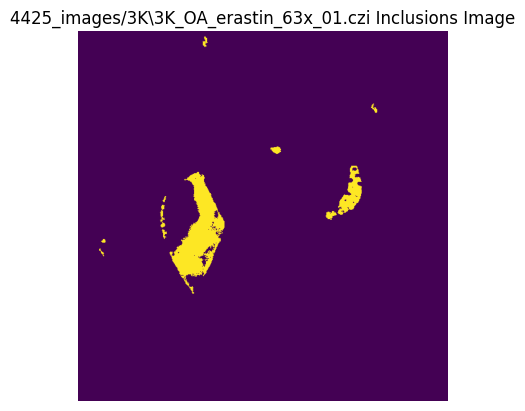

skewness > 0.25 1.6675817158882635 max value 678
Threshold: 0.35
skewness > 0.25 3.9507700540249324 max value 1171
Threshold: 0.35
skewness > 0.25 3.630980881752112 max value 827
Threshold: 0.35
skewness > 0.25 2.909923015121862 max value 1755
Threshold: 0.35
skewness > 0.25 0.7597070023914815 max value 649
Threshold: 0.35
skewness > 0.25 1.545103353105454 max value 429
Threshold: 0.35
skewness > 0.25 2.1974824398920223 max value 2585
Threshold: 0.75
skewness > 0.25 1.8218084029826158 max value 450
Threshold: 0.35
skewness > 0.25 1.557084185137334 max value 3017
Threshold: 0.75
skewness > 0.25 1.7947558324021728 max value 1867
Threshold: 0.35
skewness > 0.25 2.222127120562927 max value 2119
Threshold: 0.75
skewness > 0.25 0.3894025003894097 max value 197
Threshold: 0.35


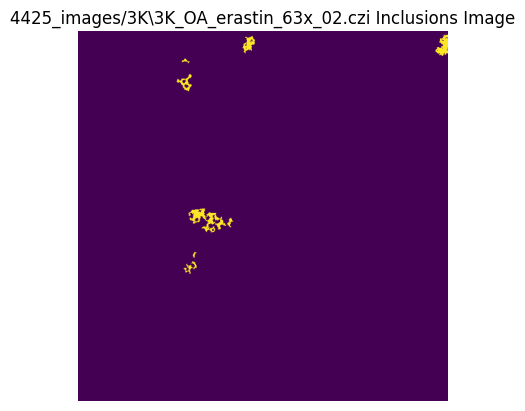

skewness > 0.25 1.5460365190210854 max value 964
Threshold: 0.35
skewness > 0.25 0.8945230076240863 max value 665
Threshold: 0.35
skewness > 0.25 2.2969713013234667 max value 1414
Threshold: 0.35
skewness > 0.25 2.596306543572894 max value 1715
Threshold: 0.35
skewness > 0.25 2.1180302599499505 max value 2895
Threshold: 0.75
skewness > 0.25 1.6413255327332403 max value 1902
Threshold: 0.35
skewness > 0.25 2.7468014111974917 max value 2340
Threshold: 0.75
skewness > 0.25 2.393919594259507 max value 3052
Threshold: 0.75
skewness > 0.25 3.273299709386067 max value 1891
Threshold: 0.35
skewness > 0.25 3.195702581996816 max value 1288
Threshold: 0.35
skewness > 0.25 3.8122737140634166 max value 1908
Threshold: 0.35
skewness > 0.25 0.3172355084674659 max value 754
Threshold: 0.35


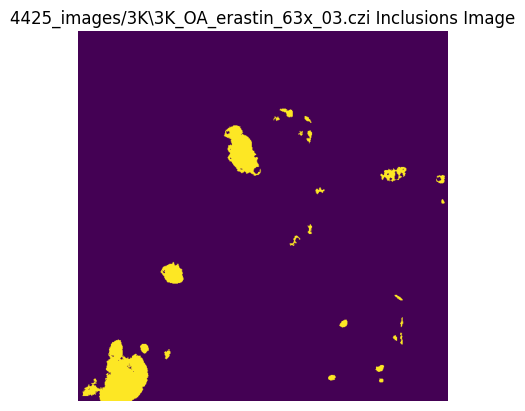

skewness > 0.25 2.101882764954373 max value 3390
Threshold: 0.75
skewness > 0.25 2.889155088103005 max value 1508
Threshold: 0.35
skewness > 0.25 2.242704095234191 max value 3749
Threshold: 0.75
skewness > 0.25 1.6166571706341415 max value 2488
Threshold: 0.75
skewness > 0.25 0.5163260812437628 max value 1771
Threshold: 0.35
skewness > 0.25 1.6551296153799904 max value 430
Threshold: 0.35
skewness > 0.25 10.771262477029666 max value 749
Threshold: 0.35
skewness > 0.25 9.587011067022505 max value 1012
Threshold: 0.35
skewness > 0.25 1.7552674005882407 max value 1316
Threshold: 0.35
skewness > 0.25 3.0381692805927383 max value 1565
Threshold: 0.35
skewness > 0.25 1.1597673141930382 max value 1125
Threshold: 0.35
skewness > 0.25 2.76951852697139 max value 815
Threshold: 0.35


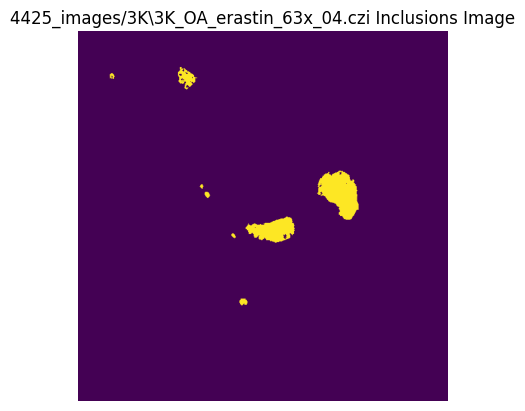

skewness > 0.25 0.7538822901592659 max value 353
Threshold: 0.35
skewness > 0.25 2.1874209147269412 max value 796
Threshold: 0.35
skewness > 0.25 2.1731544371969993 max value 1993
Threshold: 0.35
skewness > 0.25 2.6538639399780495 max value 3321
Threshold: 0.75
skewness > 0.25 2.2816667614859827 max value 1969
Threshold: 0.35
skewness > 0.25 3.8143277963664164 max value 1822
Threshold: 0.35
skewness > 0.25 1.8971054248627601 max value 4747
Threshold: 0.75
skewness > 0.25 4.289410367500432 max value 1644
Threshold: 0.35
skewness > 0.25 1.6918994745541227 max value 2699
Threshold: 0.75
skewness > 0.25 1.1177727081303956 max value 602
Threshold: 0.35
skewness > 0.25 2.571515400788949 max value 1848
Threshold: 0.35


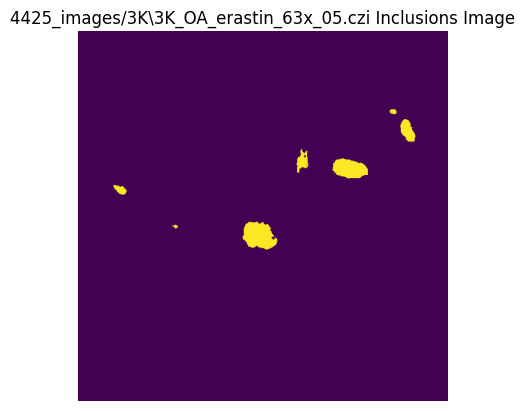

skewness > 0.25 2.7919437666283398 max value 2003
Threshold: 0.75
skewness > 0.25 3.039735936210622 max value 900
Threshold: 0.35
skewness > 0.25 2.0189358917756146 max value 2678
Threshold: 0.75
skewness > 0.25 2.6859209310819256 max value 1084
Threshold: 0.35
skewness > 0.25 2.5493735647576936 max value 1010
Threshold: 0.35
skewness > 0.25 6.058527757418971 max value 748
Threshold: 0.35
skewness > 0.25 2.0228558997914963 max value 1942
Threshold: 0.35
skewness > 0.25 1.6336954520211724 max value 2185
Threshold: 0.75
skewness > 0.25 2.6840041380399935 max value 834
Threshold: 0.35
skewness > 0.25 2.452692793883858 max value 594
Threshold: 0.35
skewness > 0.25 1.753064587550388 max value 1255
Threshold: 0.35
skewness > 0.25 2.949082651616311 max value 891
Threshold: 0.35
skewness < 0.25 $0.06927874862979679
Threshold: 0.8
skewness > 0.25 2.4116373125221275 max value 1311
Threshold: 0.35
skewness > 0.25 3.3201367094097134 max value 996
Threshold: 0.35


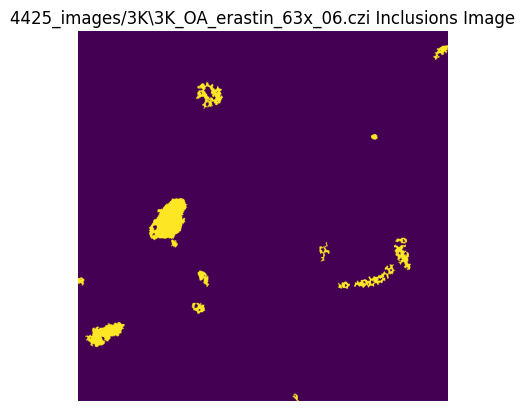

skewness > 0.25 1.9814530594289301 max value 3317
Threshold: 0.75
skewness > 0.25 3.3227242687030354 max value 2335
Threshold: 0.75
skewness > 0.25 5.087076781565717 max value 753
Threshold: 0.35
skewness > 0.25 2.8830610887825268 max value 708
Threshold: 0.35
skewness > 0.25 1.4466943072517964 max value 1624
Threshold: 0.35
skewness > 0.25 2.105700204779551 max value 2679
Threshold: 0.75
skewness > 0.25 2.2018525959265047 max value 3439
Threshold: 0.75
skewness > 0.25 3.5173388777288754 max value 1570
Threshold: 0.35
skewness > 0.25 2.6830907841062217 max value 2142
Threshold: 0.75
skewness > 0.25 1.930963057279271 max value 3584
Threshold: 0.75
skewness > 0.25 2.326593419381804 max value 3772
Threshold: 0.75


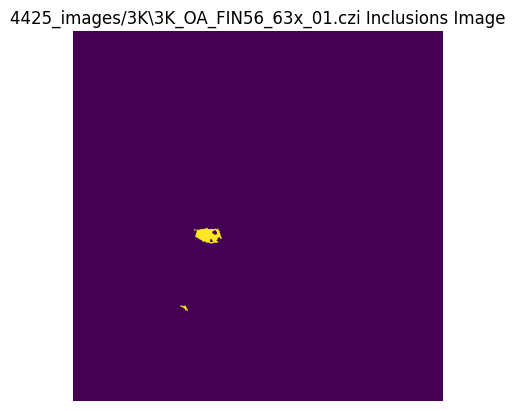

skewness > 0.25 0.2822398979244629 max value 200
Threshold: 0.35
skewness > 0.25 3.984697633355493 max value 2126
Threshold: 0.75
skewness > 0.25 2.8097073165712616 max value 1531
Threshold: 0.35
skewness > 0.25 1.6424648827114208 max value 3636
Threshold: 0.75
skewness > 0.25 1.295781573426579 max value 267
Threshold: 0.35
skewness > 0.25 2.6370998996332546 max value 1381
Threshold: 0.35
skewness > 0.25 3.4114783423425767 max value 2308
Threshold: 0.75
skewness > 0.25 0.9561632966003731 max value 880
Threshold: 0.35
skewness > 0.25 3.0730820672250276 max value 1696
Threshold: 0.35
skewness > 0.25 1.7094248359519844 max value 1023
Threshold: 0.35
skewness > 0.25 1.2829280368639688 max value 451
Threshold: 0.35
skewness > 0.25 1.7661280120573783 max value 661
Threshold: 0.35


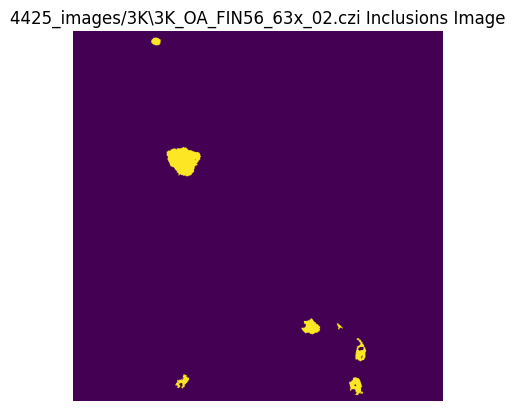

skewness > 0.25 2.692719584689759 max value 1611
Threshold: 0.35
skewness < 0.25 $0.23632222698077066
Threshold: 0.8
skewness > 0.25 2.2752346500203764 max value 2296
Threshold: 0.75
skewness > 0.25 3.0670068594304354 max value 1028
Threshold: 0.35
skewness > 0.25 1.5482990236110872 max value 2521
Threshold: 0.75
skewness > 0.25 4.46596405503472 max value 1212
Threshold: 0.35
skewness > 0.25 1.8258359151663777 max value 1092
Threshold: 0.35
skewness > 0.25 1.152689387669402 max value 4143
Threshold: 0.75


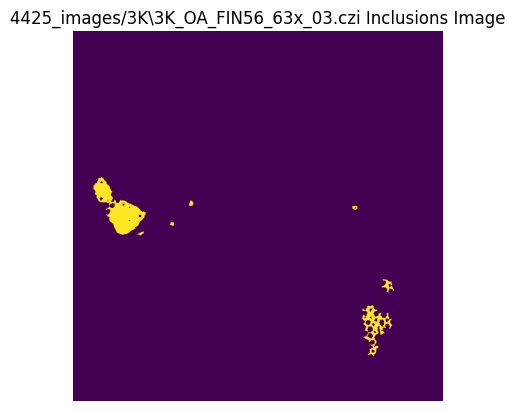

skewness > 0.25 2.9271761361299014 max value 957
Threshold: 0.35
skewness > 0.25 3.0213721690016087 max value 2064
Threshold: 0.75
skewness > 0.25 1.8734709361709887 max value 1276
Threshold: 0.35
skewness > 0.25 3.1057113523710025 max value 1704
Threshold: 0.35
skewness > 0.25 1.3752289827283708 max value 3152
Threshold: 0.75
skewness > 0.25 6.245944842981604 max value 1323
Threshold: 0.35
skewness > 0.25 1.6995067648235216 max value 979
Threshold: 0.35
skewness > 0.25 2.3712901954507046 max value 546
Threshold: 0.35
skewness > 0.25 1.4372462726308453 max value 1887
Threshold: 0.35
skewness > 0.25 1.8284832723733553 max value 2156
Threshold: 0.75
skewness > 0.25 3.2591454179467605 max value 551
Threshold: 0.35
skewness > 0.25 1.4430947879155642 max value 954
Threshold: 0.35
skewness > 0.25 2.103743713600891 max value 1074
Threshold: 0.35
skewness > 0.25 2.6996631261720863 max value 1291
Threshold: 0.35


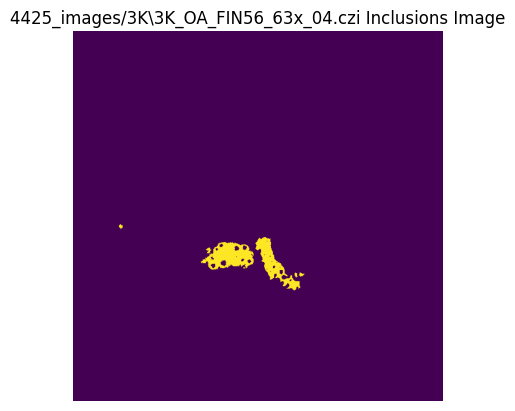

skewness > 0.25 1.8593944866845533 max value 681
Threshold: 0.35
skewness > 0.25 2.9050231164950007 max value 628
Threshold: 0.35
skewness > 0.25 2.171740494092747 max value 2370
Threshold: 0.75
skewness > 0.25 1.7478346545244619 max value 739
Threshold: 0.35
skewness > 0.25 1.5859245592313493 max value 225
Threshold: 0.35
skewness > 0.25 1.9873774303378131 max value 903
Threshold: 0.35
skewness > 0.25 2.0826222496046825 max value 539
Threshold: 0.35
skewness > 0.25 1.991210181436748 max value 1295
Threshold: 0.35
skewness > 0.25 3.3626290377248917 max value 612
Threshold: 0.35
skewness > 0.25 2.6116474119688275 max value 1739
Threshold: 0.35
skewness > 0.25 2.4541970568153464 max value 2107
Threshold: 0.75
skewness > 0.25 2.6471725162443054 max value 1150
Threshold: 0.35
skewness > 0.25 2.011834445785208 max value 1806
Threshold: 0.35
skewness > 0.25 1.848240351520075 max value 711
Threshold: 0.35
skewness > 0.25 2.765047685547135 max value 920
Threshold: 0.35
skewness > 0.25 1.233063

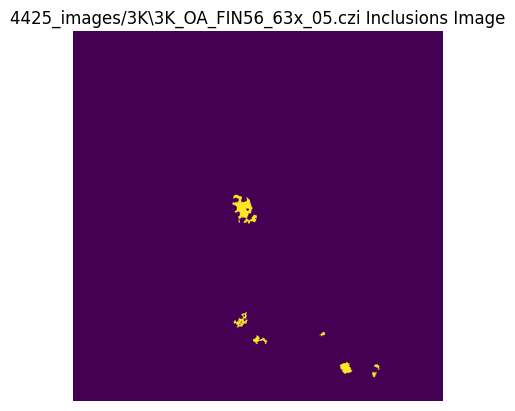

skewness < 0.25 $0.1267771270352492
Threshold: 0.8
skewness > 0.25 3.4480492984915787 max value 613
Threshold: 0.35
skewness > 0.25 2.430349996393322 max value 1207
Threshold: 0.35
skewness > 0.25 2.208967909941941 max value 1770
Threshold: 0.35
skewness > 0.25 2.596335884661931 max value 1617
Threshold: 0.35
skewness > 0.25 2.5781656785176126 max value 2967
Threshold: 0.75
skewness > 0.25 3.120896830388176 max value 3278
Threshold: 0.75
skewness > 0.25 2.3697457572355862 max value 2525
Threshold: 0.75
skewness > 0.25 1.7964200412962121 max value 2554
Threshold: 0.75


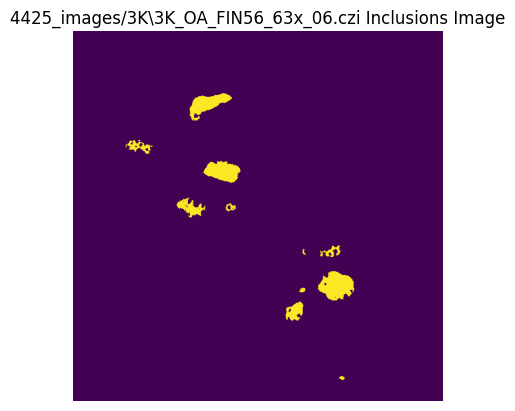

skewness > 0.25 1.235074993763827 max value 727
Threshold: 0.35
skewness > 0.25 1.008452153108999 max value 585
Threshold: 0.35
skewness > 0.25 1.8903245728687381 max value 1148
Threshold: 0.35
skewness > 0.25 2.1781582021214785 max value 2278
Threshold: 0.75
skewness > 0.25 2.198040967199162 max value 1920
Threshold: 0.35
skewness > 0.25 2.5964951549360293 max value 1019
Threshold: 0.35
skewness > 0.25 2.396359281862909 max value 644
Threshold: 0.35
skewness > 0.25 2.29091537568109 max value 2168
Threshold: 0.75
skewness > 0.25 1.4058743787661485 max value 1176
Threshold: 0.35
skewness > 0.25 2.3631288595354314 max value 2131
Threshold: 0.75
skewness > 0.25 1.16054845104507 max value 4239
Threshold: 0.75
skewness > 0.25 2.290210630388123 max value 2456
Threshold: 0.75
skewness > 0.25 2.040195320901624 max value 1342
Threshold: 0.35
skewness > 0.25 2.3363032291896912 max value 302
Threshold: 0.35
skewness < 0.25 $0.0009780355573591217
Threshold: 0.8


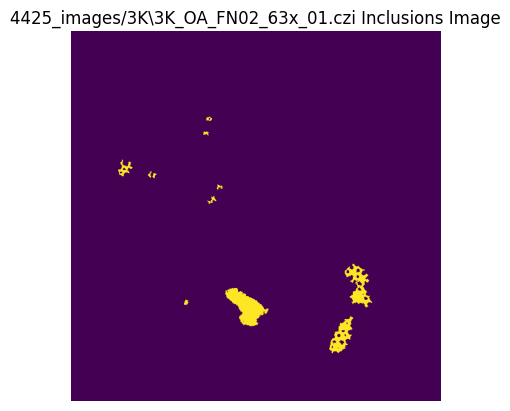

skewness > 0.25 1.996461804504872 max value 1030
Threshold: 0.35
skewness > 0.25 1.6804143046215676 max value 1618
Threshold: 0.35
skewness > 0.25 1.6916670179665874 max value 1198
Threshold: 0.35
skewness > 0.25 1.2609806422681378 max value 1584
Threshold: 0.35
skewness > 0.25 1.5769532218978919 max value 1213
Threshold: 0.35
skewness > 0.25 2.41005799067498 max value 410
Threshold: 0.35
skewness > 0.25 1.701359553866227 max value 1759
Threshold: 0.35
skewness > 0.25 1.7922340747338041 max value 867
Threshold: 0.35
skewness < 0.25 $0.011438023221260415
Threshold: 0.8
skewness > 0.25 1.0401243391505175 max value 1779
Threshold: 0.35


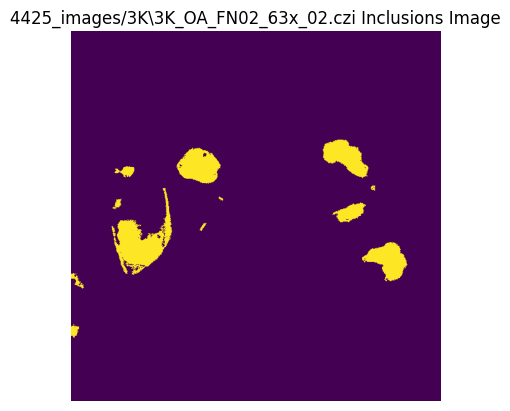

skewness > 0.25 2.1606674683877656 max value 1717
Threshold: 0.35
skewness > 0.25 2.294641433487024 max value 1576
Threshold: 0.35
skewness > 0.25 1.6898685801630164 max value 1389
Threshold: 0.35
skewness > 0.25 3.6606512294988116 max value 1591
Threshold: 0.35
skewness > 0.25 5.830714422932248 max value 1035
Threshold: 0.35
skewness > 0.25 2.763442899981423 max value 1072
Threshold: 0.35
skewness > 0.25 1.1620521143782658 max value 659
Threshold: 0.35
skewness > 0.25 2.121357019577639 max value 1825
Threshold: 0.35
skewness > 0.25 0.9779510541332522 max value 1203
Threshold: 0.35
skewness > 0.25 2.663867180404918 max value 1898
Threshold: 0.35
skewness > 0.25 4.991720577485568 max value 521
Threshold: 0.35
skewness > 0.25 3.9564207784105747 max value 378
Threshold: 0.35


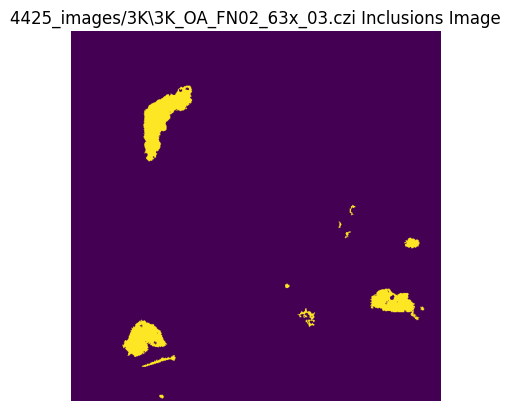

skewness > 0.25 2.414851511042633 max value 647
Threshold: 0.35
skewness > 0.25 2.157127074385349 max value 1171
Threshold: 0.35
skewness > 0.25 2.4252951321274616 max value 962
Threshold: 0.35
skewness > 0.25 3.382859959645796 max value 715
Threshold: 0.35
skewness > 0.25 1.8494762173028656 max value 2009
Threshold: 0.75
skewness > 0.25 1.8582375390289532 max value 803
Threshold: 0.35
skewness > 0.25 2.0296740365513686 max value 2371
Threshold: 0.75
skewness > 0.25 0.5378987924561361 max value 2206
Threshold: 0.75
skewness > 0.25 1.428999598523152 max value 2475
Threshold: 0.75
skewness > 0.25 2.0462511797632867 max value 2185
Threshold: 0.75
skewness > 0.25 1.8773993235391813 max value 827
Threshold: 0.35
skewness > 0.25 2.8825510707411395 max value 715
Threshold: 0.35
skewness > 0.25 2.782491656049617 max value 2044
Threshold: 0.75
skewness > 0.25 0.995382016975235 max value 1267
Threshold: 0.35
skewness > 0.25 0.45028416175887553 max value 312
Threshold: 0.35
skewness > 0.25 2.9517

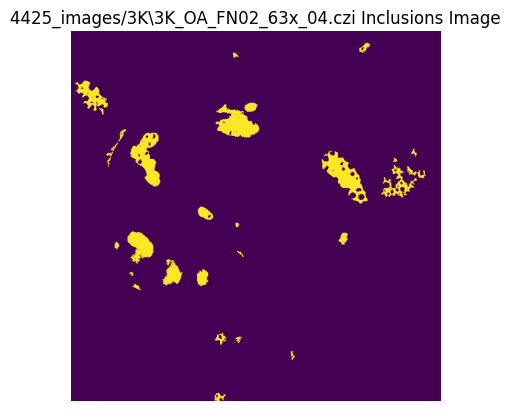

In [ ]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()


    df_summary = []
    
    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 

        red, green = extract_channels(image_squeezed)
        df_cell_summary = analysis(red, green, path)
        df_summary.append(df_cell_summary)

    combined_cell_summary_df = pd.concat(df_summary, ignore_index=True)
    output_summary_path = os.path.join(output_dir, '4425_3K.xlsx')
    combined_cell_summary_df.to_excel(output_summary_path, index=False)




if __name__ == "__main__":
    image_folder = '4425_images/3K'
    main(image_folder)